In [64]:
# # Install some packages
# %pip install rasterio
# %pip install earthpy

In [65]:
# Imports
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import earthpy.plot as ep

In [66]:
# Parameter
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
LABEL = ['classvalue']
CLASSES = [1, 2, 3, 4, 5, 6]
PALETTE = ['#8B0100', '#B86401', '#008080', '#87CEFA', '#65A300', '#006401']
SAMPLE_PATH = 'ndvi_data/Samples_LC_Jambi_2023_ALLFEATURES.csv'
IMAGE_PATH = 'ndvi_data/Landsat_Bandung.tif'

/home/seviko/python/py311/lib/python3.11/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


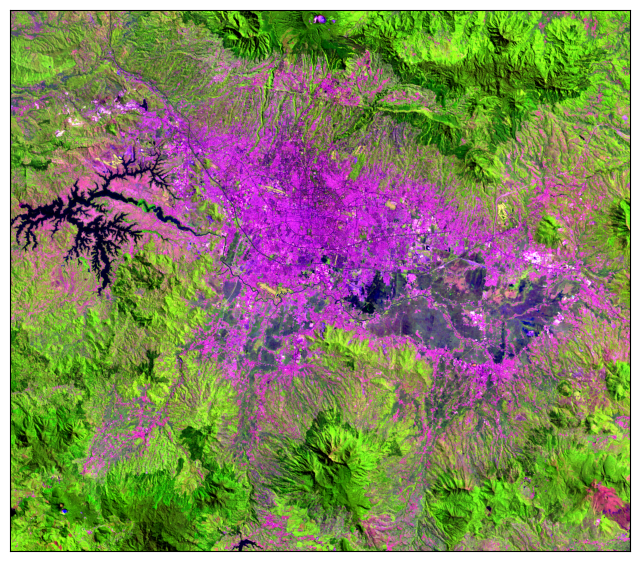

In [67]:
# Load image
image = rasterio.open(IMAGE_PATH)
height = image.height
width = image.width
shape = (height, width)

# (Optional) Visualize the image
image_vis = []
for x in [6, 5, 4]:
    image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
ep.plot_rgb(image_vis, figsize=(8, 8), stretch=True)
plt.show()

In [68]:
# Read samples
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac=1)
# Ensure label is integer type
samples['classvalue'] = samples['classvalue'].astype('int32')
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,NDVI,elevation,classvalue,sample
19523,0.013262,0.017223,0.045987,0.025802,0.331245,0.083608,0.042440,0.562762,0.772857,0.596929,-0.756185,-0.596929,0.326603,0.855467,9,5,test
610,0.065870,0.083552,0.118807,0.135500,0.255978,0.318842,0.235105,0.208824,0.042503,-0.109365,-0.365997,0.109365,0.151165,0.307751,25,1,train
5973,0.037242,0.043210,0.069582,0.070105,0.228230,0.275778,0.164897,0.298397,0.161099,-0.094339,-0.532709,0.094339,0.251614,0.530025,12,2,train
15071,0.017057,0.023671,0.043334,0.031014,0.043540,0.022200,0.015352,0.029765,0.478626,0.324612,-0.002374,-0.324612,0.182345,0.168016,638,4,train
10093,0.023107,0.026545,0.057125,0.039291,0.319874,0.150735,0.065086,0.517095,0.661854,0.359404,-0.696949,-0.359404,0.396850,0.781208,11,3,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24249,0.011544,0.013675,0.035785,0.020591,0.254327,0.091830,0.036404,0.458194,0.749571,0.469432,-0.753303,-0.469432,0.432228,0.850201,8,6,train
16651,0.023932,0.027810,0.042852,0.033310,0.205267,0.148535,0.066090,0.359277,0.512894,0.160351,-0.654582,-0.160351,0.384135,0.720762,14,5,train
21808,0.029859,0.036266,0.071136,0.046029,0.421115,0.190129,0.079345,0.657912,0.682912,0.377895,-0.710976,-0.377895,0.411111,0.802935,13,6,train
17185,0.026737,0.032430,0.061717,0.043182,0.339825,0.181232,0.078382,0.547030,0.625150,0.304367,-0.692598,-0.304367,0.396164,0.774508,10,5,train


In [69]:
# Split into train and test based on 'sample' column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Prepare data for TFDF
train_data = train[FEATURES + LABEL]
test_data = test[FEATURES + LABEL]

In [70]:
# Convert to TensorFlow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=LABEL[0])
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=LABEL[0])

In [71]:
# from ydata_profiling import ProfileReport
# ProfileReport(train)

In [72]:
# Define the Random Forest model
rf_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

# Train the model
rf_model.fit(train_ds)

Use /tmp/tmp8jjivnaa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.246457. Found 23814 examples.
Training model...


I0000 00:00:1732672221.435986  219423 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732672221.436027  219423 kernel.cc:783] Collect training examples
I0000 00:00:1732672221.436038  219423 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732672221.436093  219423 kernel.cc:401] Number of batches: 24
I0000 00:00:1732672221.436098  219423 kernel.cc:402] Number of examples: 23814
I0000 00:00:1732672221.437498  219423 kernel.cc:802] Training dataset:
Number of records: 23814
Number of columns: 10

Number of columns by type:
	NUMERICAL: 9 (90%)
	CATEGORICAL: 1 (10%)

Columns:

NUMERICAL: 9 (90%)
	0: "B1" NUMERICAL mean:0.0367305 min:-0

Model trained in 0:00:03.234968
Compiling model...


I0000 00:00:1732672224.630271  219423 decision_forest.cc:761] Model loaded with 300 root(s), 365802 node(s), and 9 input feature(s).
I0000 00:00:1732672224.630359  219423 abstract_model.cc:1404] Engine "RandomForestGeneric" built
2024-11-27 08:50:24.630378: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.


In [73]:
# Evaluate the model
evaluation = rf_model.evaluate(test_ds)
print(f"Model evaluation: {evaluation}")

5/5 [==============================] - 0s 45ms/step - loss: 0.0000e+00
Model evaluation: 0.0


5/5 [==============================] - 0s 46ms/step


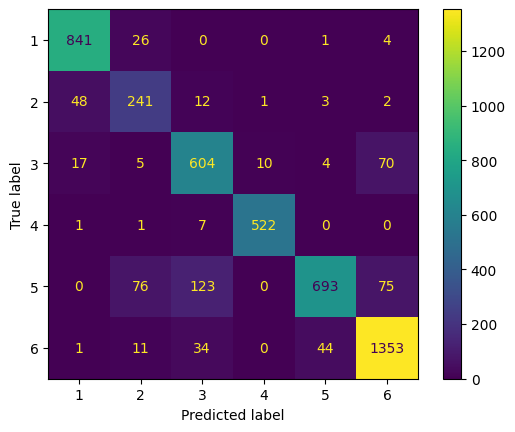

              precision    recall  f1-score   support

           1       0.93      0.96      0.94       872
           2       0.67      0.79      0.72       307
           3       0.77      0.85      0.81       710
           4       0.98      0.98      0.98       531
           5       0.93      0.72      0.81       967
           6       0.90      0.94      0.92      1443

    accuracy                           0.88      4830
   macro avg       0.86      0.87      0.86      4830
weighted avg       0.89      0.88      0.88      4830



In [74]:
# Predictions on test data
test_predictions = rf_model.predict(test_ds)
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = test_data[LABEL[0]].values

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=CLASSES)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot()
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes))

3176/3176 [==============================] - 74s 23ms/step


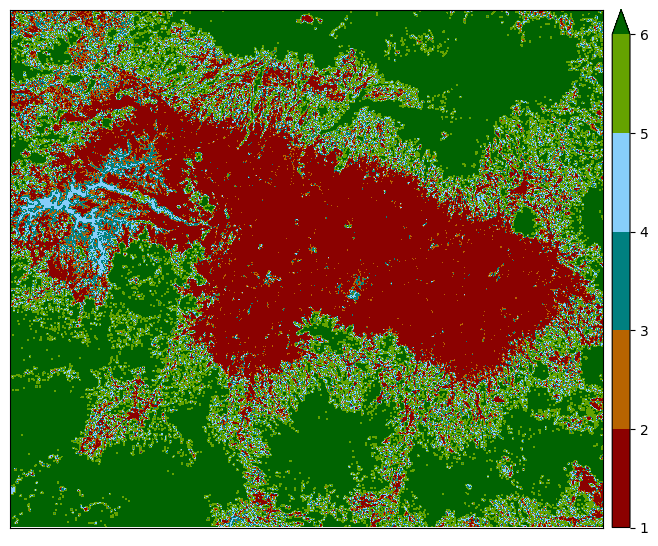

In [75]:
# Predict on image data
image_data = []
for i, feature in enumerate(FEATURES):
    band_data = image.read(i + 1).flatten()
    image_data.append(band_data)

# Create DataFrame for image data
image_df = pd.DataFrame(np.array(image_data).T, columns=FEATURES)

# Convert to TensorFlow dataset
image_ds = tfdf.keras.pd_dataframe_to_tf_dataset(image_df)

# Predict on image data
image_predictions = rf_model.predict(image_ds)
image_predicted_classes = np.argmax(image_predictions, axis=1)

# Reshape predictions to image dimensions
image_predicted_classes = image_predicted_classes.reshape(shape)

# Visualize the predictions
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(image_predicted_classes, cmap=cmap, norm=norm, figsize=(8, 8))
plt.show()